## Import relevant modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

In [2]:
# Option to display more columns of a data frame
pd.set_option("display.max_columns", 40)

## Load airbnb data for Boston and have a look

In [3]:
# Paths to the files
path1 = r"./Airbnb Boston Data/calendar.csv"
path2 = r"./Airbnb Boston Data/listings.csv"
path3 = r"./Airbnb Boston Data/reviews.csv"

path4 = r"./Airbnb Seattle Data/calendar.csv"
path5 = r"./Airbnb Seattle Data/listings.csv"
path6 = r"./Airbnb Seattle Data/reviews.csv"

# Load each file and add city as a column where necessary
df_calendar_boston = pd.read_csv(path1, sep = ",")
df_calendar_boston['city'] = 'Boston'
df_listings_boston = pd.read_csv(path2, sep = ",")
df_reviews_boston = pd.read_csv(path3, sep = ",")
df_reviews_boston['city'] = 'Boston'

df_calendar_seattle = pd.read_csv(path4, sep = ",")
df_calendar_seattle['city'] = 'Seattle'
df_listings_seattle = pd.read_csv(path5, sep = ",")
df_reviews_seattle = pd.read_csv(path3, sep = ",")
df_reviews_seattle['city'] = 'Seattle'

# Concatenate the data frames for the two cities for each dataset
df_calendar = pd.concat([df_calendar_boston, df_calendar_seattle])
df_listings = pd.concat([df_listings_boston, df_listings_seattle])
df_reviews = pd.concat([df_reviews_boston, df_reviews_seattle])

In [4]:
df_calendar_boston.columns

Index(['listing_id', 'date', 'available', 'price', 'city'], dtype='object')

# Data cleaning

In [5]:
# Look at first rows of calendar
df_calendar.head()

,listing_id,date,available,price,city
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston


In [6]:
# dtypes of calendar
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
city          object
dtype: object

In [7]:
# Look at values for 'available'
df_calendar.available.unique()

array(['f', 't'], dtype=object)

### The values for available consist only of 'f' and 't' without missing values. Thus 'available' can be converted to boolian

In [8]:
# convert 'date' to date format, 'available' to boolian and 'price' to float
df_calendar['date'] = pd.to_datetime(df_calendar.date, errors = 'coerce')
df_calendar['available'] = df_calendar['available'].apply(lambda x: 0 if x.strip() == 'f' else 1).astype('bool')
df_calendar['price'] = df_calendar['price'].str.replace(r"[\$,]", "", regex = True).astype('float')

In [9]:
# Percentage of missing values for each column in calendar
df_calendar.isna().mean().sort_values(ascending = False)

price         0.416243
listing_id    0.000000
date          0.000000
available     0.000000
city          0.000000
dtype: float64

In [10]:
# Look at first rows of listings
df_listings.head(4)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,...,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,...,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,...,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,...,2016-09-06,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,There are buses that stop right in front of th...,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,6031442,...,2016-09-06,1,2016-08-28,2016-08-28,100.0,10.0,

In [10]:
# string columns in listings
df_listings.select_dtypes(include = 'object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'ha

In [11]:
# Look at string columns I suppose to be not string
df_listings.loc[:,['host_since', 'host_response_time', 'host_response_rate',
                   'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
                   'host_identity_verified', 'is_location_exact', 'price', 'weekly_price',
                   'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
                   'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review',
                   'last_review', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                   'require_guest_phone_verification'
                  ]].head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,2015-04-15,NaN,NaN,NaN,f,t,f,t,$250.00,NaN,NaN,NaN,$35.00,$0.00,2 weeks ago,NaN,2016-09-06,NaN,NaN,f,f,f,f
1,2012-06-07,within an hour,100%,100%,f,t,t,t,$65.00,$400.00,NaN,$95.00,$10.00,$0.00,a week ago,NaN,2016-09-06,2014-06-01,2016-08-13,f,t,f,f
2,2009-05-11,within a few hours,100%,88%,t,t,t,t,$65.00,$395.00,"$1,350.00",NaN,NaN,$20.00,5 days ago,NaN,2016-09-06,2009-07-19,2016-08-05,f,f,t,f
3,2013-04-21,within a few hours,100%,50%,f,t,f,f,$75.00,NaN,NaN,$100.00,$50.00,$25.00,a week ago,NaN,2016-09-06,2016-08-28,2016-08-28,f,f,f,f
4,2014-05-11,within an hour,100%,100%,t,t,t,t,$79.00,NaN,NaN,NaN,$15.00,$0.00,2 weeks ago,NaN,2016-09-06,2015-08-18,2016-09-01,f,f,f,f


### It seems I was only wrong with 'host_response_time'. Also 'calendar_updated' seems not so handy. One could consider to split it into the numeric part and in a field containing the unit of measurement.

In [12]:
# Check if potential boolian fields have missing values
df_listings.loc[:, ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
           'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
           'require_guest_phone_verification'
          ]].isna().mean().sort_values(ascending = False)

host_is_superhost                   0.00027
host_has_profile_pic                0.00027
host_identity_verified              0.00027
is_location_exact                   0.00000
requires_license                    0.00000
instant_bookable                    0.00000
require_guest_profile_picture       0.00000
require_guest_phone_verification    0.00000
dtype: float64

In [13]:
len(df_listings.calendar_updated.unique())

38

In [14]:
# Convert data types
# dates
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'], errors = 'coerce')
df_listings['calendar_last_scraped'] = pd.to_datetime(df_listings['calendar_last_scraped'], errors = 'coerce')
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors = 'coerce')
df_listings['last_review'] = pd.to_datetime(df_listings['last_review'], errors = 'coerce')
# boolian
d = {'f': False, 't': True}
df_listings['host_is_superhost'] = df_listings.host_is_superhost.str.strip().map(d).astype('boolean')
df_listings['host_has_profile_pic'] = df_listings.host_has_profile_pic.str.strip().map(d).astype('boolean')
df_listings['host_identity_verified'] = df_listings.host_identity_verified.str.strip().map(d).astype('boolean')
df_listings['is_location_exact'] = df_listings.is_location_exact.str.strip().map(d).astype('boolean')
df_listings['requires_license'] = df_listings.requires_license.str.strip().map(d).astype('boolean')
df_listings['instant_bookable'] = df_listings.instant_bookable.str.strip().map(d).astype('boolean')
df_listings['has_availability'] = df_listings.has_availability.str.strip().map(d).astype('boolean')
df_listings['require_guest_profile_picture'] = df_listings.require_guest_profile_picture.str.strip().map(d).astype('boolean')
df_listings['require_guest_phone_verification'] = df_listings.require_guest_phone_verification.str.strip().map(d).astype('boolean')
# float
df_listings['price'] = df_listings.price.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['weekly_price'] = df_listings.weekly_price.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['monthly_price'] = df_listings.monthly_price.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['security_deposit'] = df_listings.security_deposit.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['weekly_price'] = df_listings.weekly_price.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['cleaning_fee'] = df_listings.cleaning_fee.replace(r"[^0-9\.]", "", regex = True).astype('float')
df_listings['extra_people'] = df_listings.extra_people.replace(r"[^0-9\.]", "", regex = True).astype('float')
# Percentage
df_listings['host_response_rate'] = df_listings.host_response_rate.str.strip("%").astype('float')/100
df_listings['host_acceptance_rate'] = df_listings.host_acceptance_rate.str.strip("%").astype('float')/100


In [15]:
# Percentage of missing values in listings
df_listings.isna().mean().sort_values(ascending = False)

license            1.000000
square_feet        0.979333
interaction        0.725652
access             0.716872
house_rules        0.676753
                     ...   
bed_type           0.000000
amenities          0.000000
price              0.000000
guests_included    0.000000
country            0.000000
Length: 95, dtype: float64

In [16]:
# Are there fields with only one unique value?
df_listings.nunique().sort_values()[df_listings.nunique() == 1]

country                1
has_availability       1
country_code           1
jurisdiction_names     1
experiences_offered    1
requires_license       1
dtype: int64

In [17]:
# Look at unique-value fields
df_listings.loc[:, ['country_code','country','has_availability',
                    'jurisdiction_names','experiences_offered',
                    'requires_license'
                   ]].head()

,country_code,country,has_availability,jurisdiction_names,experiences_offered,requires_license
0,US,United States,<NA>,NaN,none,False
1,US,United States,<NA>,NaN,none,False
2,US,United States,<NA>,NaN,none,False
3,US,United States,<NA>,NaN,none,False
4,US,United States,<NA>,NaN,none,False


In [19]:
# Since the field license is always missing we can drop it
# we can also drop all fields with one distinct value since they don't add any information
df_listings = df_listings.drop(columns = ['license', 'country_code','country','has_availability',
                    'jurisdiction_names','experiences_offered',
                    'requires_license'])

In [20]:
# First rows of listings
df_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,...,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,...,0,0,0,2016-09-06,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,moderate,False,False,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,...,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,False,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,https://www.airbnb.com/users/show/16701,...,46,61,319,2016-09-06,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,True,False,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,There are buses that stop right in front of th...,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pi

In [21]:
# Look at first rows of reviews
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,Boston
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,Boston
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,Boston
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,Boston
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,Boston


In [22]:
# What dtypes?
df_reviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
city             object
dtype: object

In [23]:
# Only 'date' has to be converted from object to date
df_reviews['date'] = pd.to_datetime(df_reviews.date, errors = 'coerce')

In [24]:
# Missing values percentage
df_reviews.isna().mean().sort_values(ascending = False)

comments         0.000776
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
city             0.000000
dtype: float64

In [25]:
# Fields with one distinct value?
df_reviews.nunique().sort_values()

city                 2
date              2045
listing_id        2829
reviewer_name    14775
reviewer_id      63789
comments         67311
id               68275
dtype: int64

### mean price per listing_id

In [26]:
df_calendar.groupby(['listing_id']).price.mean().sort_values(ascending = False)

listing_id
12972378    4000.000000
8303267     1724.624625
14798673    1345.000000
3308979     1301.818182
10882267    1250.000000
               ...     
14673441            NaN
14722711            NaN
14774868            NaN
14809866            NaN
14852273            NaN
Name: price, Length: 7403, dtype: float64

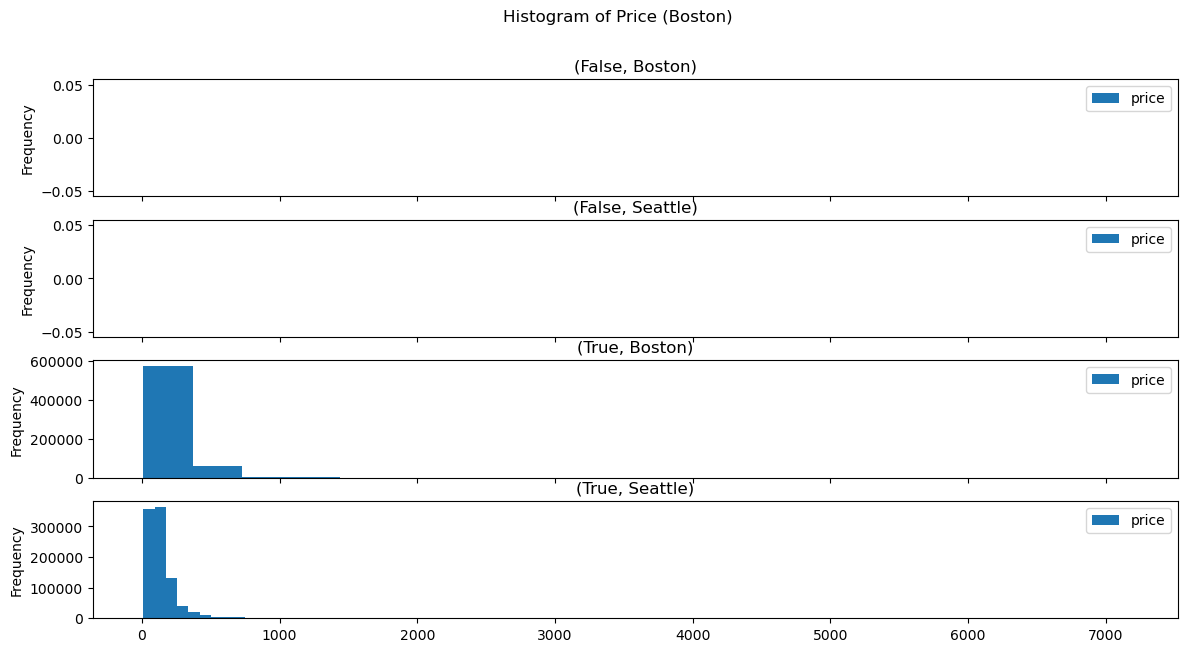

In [27]:
df_calendar.plot.hist(column = 'price', by = ['available', 'city'], sharex = True, bins = 20, figsize = (14,7), title = "Histogram of Price (Boston)");

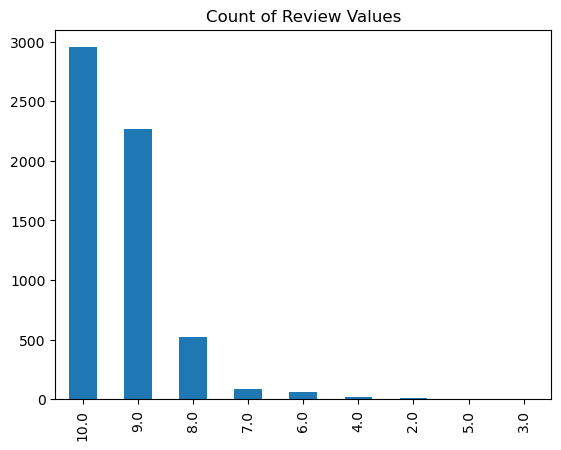

In [28]:
df_listings.review_scores_value.value_counts().sort_values(ascending = False).plot.bar(title = 'Count of Review Values');

# Can you describe the vibe of each neighborhood using listing descriptions?

In [45]:
# Are there missing neighborhoods or descriptions?
df_listings.loc[:,['neighbourhood', 'description']].isna().mean()

neighbourhood    0.129542
description      0.000000
dtype: float64

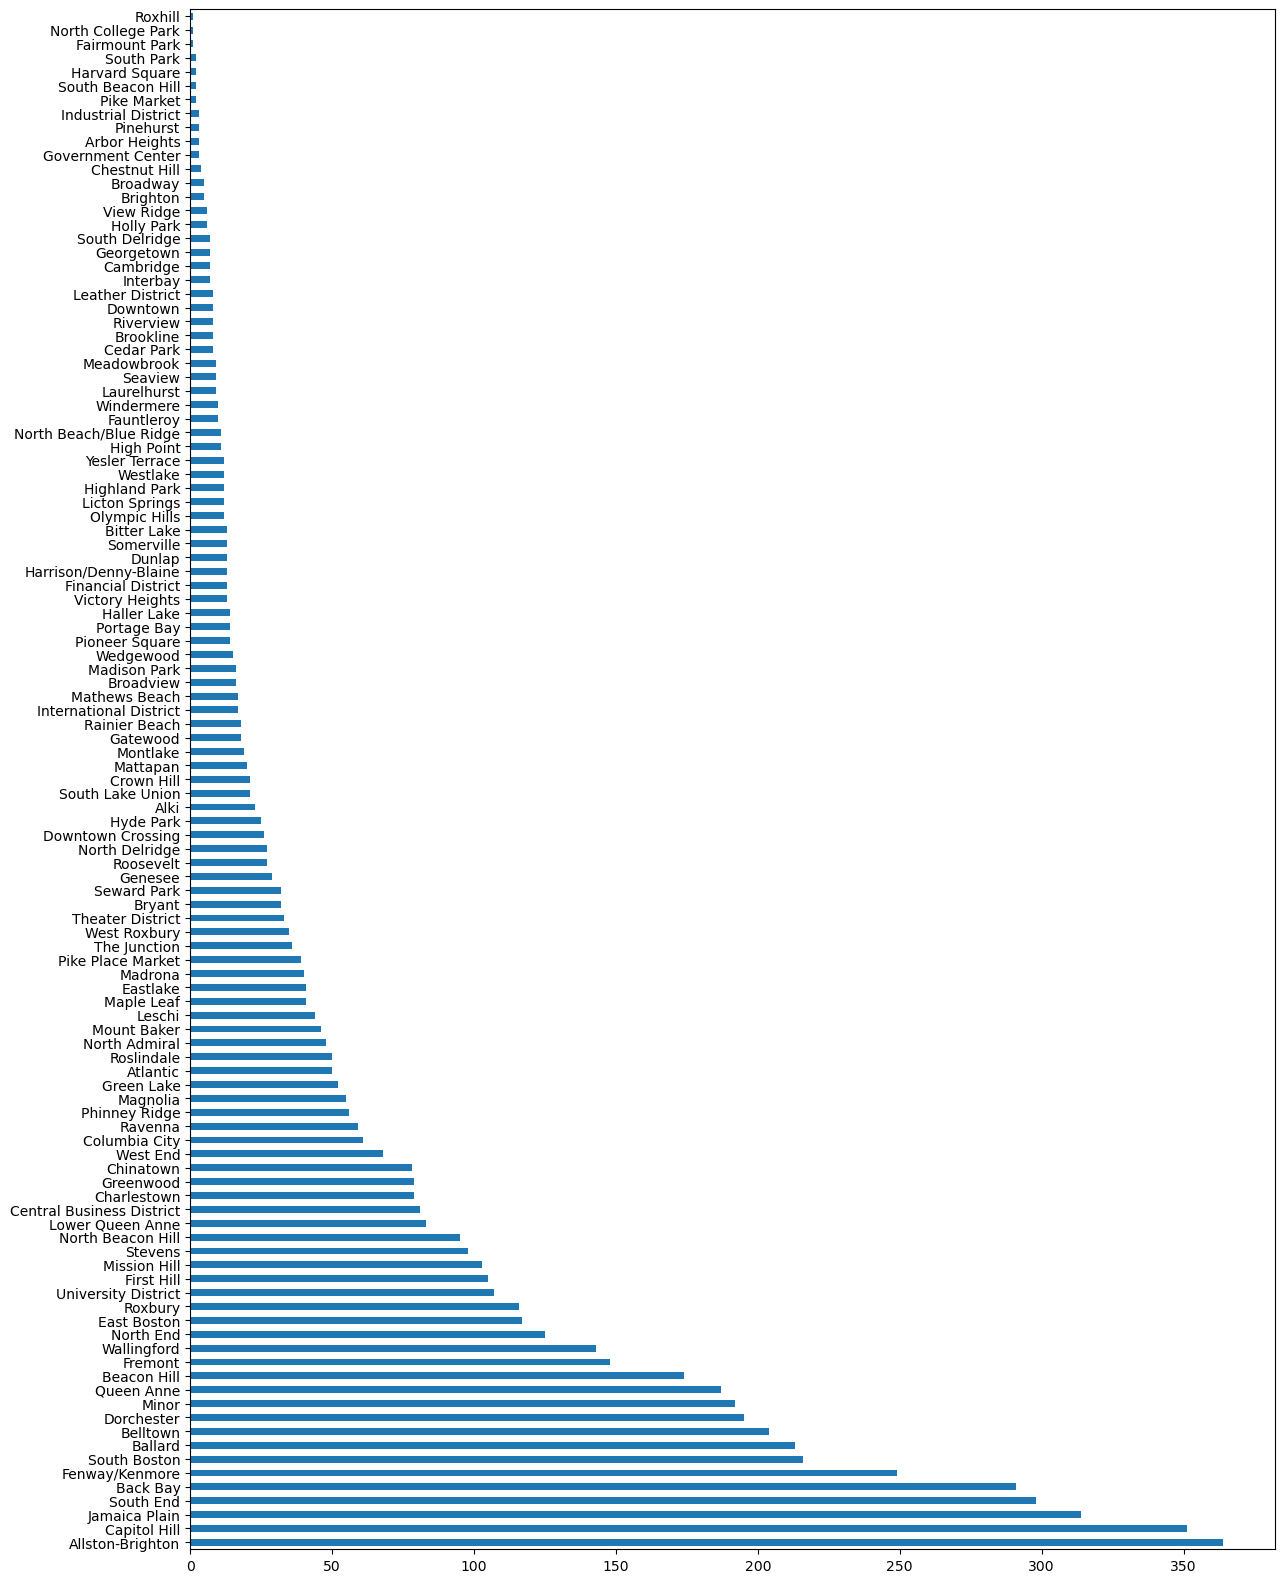

In [86]:
# We drop every row with missing neigbourhood and only keep 'neighbourhood' and 'description'
df_neighbourhood = df_listings.dropna(subset = ['neighbourhood']).loc[:, ['neighbourhood','description']]
fig = df_neighbourhood.neighbourhood.value_counts().plot(kind = 'barh', figsize = (14, 20));

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [90]:
tfidf = TfidfVectorizer()
vec = tfidf.fit_transform(df_neighbourhood.neighbourhood).toarray()

In [108]:
df_neighbourhood.shape

(6444, 2)

In [106]:
pca.explained_variance_ratio_.cumsum()

array([0.07005615, 0.13318702, 0.18897884, 0.2380925 , 0.28266311,
       0.32220308, 0.35901501, 0.39519164, 0.42888742, 0.46107233,
       0.49220826, 0.52233507, 0.54912067, 0.57266069, 0.59541596,
       0.61748293, 0.63731146, 0.65448124, 0.66974783, 0.6839407 ,
       0.69666132, 0.70927464, 0.72169366, 0.73394922, 0.74529374,
       0.75535612, 0.76526316, 0.77493914, 0.78439605, 0.79345373,
       0.80211992, 0.81032419, 0.81847597, 0.82652699, 0.83408606,
       0.84129156, 0.84814093, 0.85474277, 0.86127676, 0.86773752,
       0.87361923, 0.87891097, 0.88390853, 0.8886544 , 0.89332839,
       0.89795533, 0.90245221])